Import the necessary libraries to be used in the implementation of the Algorithms


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from matplotlib.patches import Arc, Circle, Rectangle
from sklearn.metrics import roc_curve, auc, confusion_matrix, log_loss, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

**Feature Engineering**

The initial dataset contained the data from 2021 season till 2024 season of the National Basketball Assossciation(NBA).

The following features were engineered and addeed to the dataset to provide more context to the data as well see how various factors had an effect on if a SHOT was 'MADE' or 'MISSED':

**1. TIME_REMAINING_QUARTER**:
**What?**: TIME_REMAINING_QUARTER combined the mis left and seconds left to display the time in total in seconds.

**Why use it?**: The main reason was to see how a lack of time had an effect on the shot made. Did a lack of time hurry the player into making a shot and miss which other wise he would have made it, if not under pressure.

**Relevance**: This would give a good idea on how TIME influenced a SHOT_MADE.

**2. CONGESTION_PROXY**:

**What?**: It takes the ZONE_RANGE column and quantifies the level of Congestion around the Shooter.
The level or degree of cngestion ranges from 1 to 2.5 incrementing for every 0.5.
With 1.0 being Highly COngested meaning shots close to the basket and 2.5 indicating LOW CONGESTION meaning its a long distance Shot.

**Why use it?**: Shot difficulty often increases with higher congestion. Players closer to the basket face more defensive pressure, whereas long-range shots usually have lower congestion. Helps measure shot difficulty in combination with distance.

**Relevance**: Important for analyzing shot success under different congestion levels.


**3. RELATIVE_SHOT_DIFFICULTY**:

**What?**: This feature calculates the shot difficulty relative to congestion and is calculated by (RELATIVE_SHOT_DIFFICULTY = SHOT_DISTANCE / CONGESTION_PROXY).


**Why use it?**: Combines distance and congestion into a single metric to evaluate shot difficulty.

**Relevance**: Essential for analyzing whether players perform better under challenging conditions (e.g., high congestion or long-distance shots).
Helps predict shot success by incorporating both spatial and defensive elements.

**4. SHOT_CONGESTION**:

**What?**: This categorizes the ZONE_RANGE into different congestion levels. Classifying it into HIGH, MEDIUM, LOW, with HIGH being clo-range Shots nad LOW being Long-range Shots.


**Why use it?**: Useful for visualizations and decision-tree-based models.

**Relevance**: Explains how shot success correlates with defensive congestion qualitatively.

**5. IS_CLUTCH**:

**What?**: A binary feature indicating whether the shot was taken during "clutch" time (final 2 minutes and 30 seconds of a quarter).
Formula: IS_CLUTCH = (MINS_LEFT < 2) & (SECS_LEFT < 30).


**Why use it?**: Clutch situations significantly influence shot decisions and success rates. Players take more high-risk, high-reward shots under pressure.
Highlights the importance of game context in shot success analysis.

**Relevance**: Provides a context-sensitive feature that complements shot location and congestion.



The following is the code to calculate the features and add them to the dataset:


In [ ]:
# Read and load the dataset
data_file = pd.read_csv("combined_data.csv")

#Define and add new field TIME_REMAINING_QUARTER to the dataset
data_file['TIME_REMAINING_QUARTER'] = data_file['MINS_LEFT'] * 60 + data_file['SECS_LEFT']

# Define CONGESTION_PROXY and RELATIVE_SHOT_DIFFICULTY and add them as new columns
def congestion_value(zone_range):
    if zone_range in ['Less Than 8 ft.']:
        return 1.0
    elif zone_range in ['8-16 ft.']:
        return 1.5
    elif zone_range in ['16-24 ft.']:
        return 2.0
    else:
        return 2.5

data_file['CONGESTION_PROXY'] = data_file['ZONE_RANGE'].apply(congestion_value)
data_file['RELATIVE_SHOT_DIFFICULTY'] = data_file['SHOT_DISTANCE'] / data_file['CONGESTION_PROXY']

# Define SHOT_CONGESTION and SHOT_CONGESTION_NUMERIC and add them as new columns
def congestion_category(zone_range):
    if zone_range in ['Less Than 8 ft.']:
        return 'High'
    elif zone_range in ['8-16 ft.', '16-24 ft.']:
        return 'Medium'
    elif zone_range == '24+ ft.':
        return 'Low'

data_file['SHOT_CONGESTION'] = data_file['ZONE_RANGE'].apply(congestion_category)
congestion_mapping = {'High': 3, 'Medium': 2, 'Low': 1}
data_file['SHOT_CONGESTION_NUMERIC'] = data_file['SHOT_CONGESTION'].map(congestion_mapping)

data_file['SHOT_MADE'] = data_file['SHOT_MADE'].fillna(data_file['SHOT_MADE'].mode()[0])

# Define IS_CLUTCH and add it to the dataset as a new column
data_file['IS_CLUTCH'] = ((data_file['MINS_LEFT'] < 2) &
                                   (data_file['SECS_LEFT'] < 30)).astype(int)

# Save the file as final dataset
data_file.to_csv("final.csv", index=False)

**AN OVERVIEW OF THE DATASET AFTER ADDING NEW FEATURES:**

In [ ]:
df_sample = pd.read_csv("final.csv")
df_sample.head(10)

,SEASON_1,PLAYER_ID,HOME_TEAM,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_NAME,ZONE_RANGE,LOC_X,...,QUARTER,MINS_LEFT,SECS_LEFT,TIME_REMAINING,TIME_REMAINING_QUARTER,CONGESTION_PROXY,RELATIVE_SHOT_DIFFICULTY,SHOT_CONGESTION,SHOT_CONGESTION_NUMERIC,IS_CLUTCH
0,2021,203493,True,False,Jump Shot,3PT Field Goal,Right Corner 3,Right Side,24+ ft.,2.32,...,4,1,21,81,81,2.5,9.2,Low,1.0,1
1,2021,203493,True,True,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side,16-24 ft.,1.87,...,4,1,54,114,114,2.0,9.0,Medium,2.0,0
2,2021,203944,True,True,Driving Layup Shot,2PT Field Goal,Restricted Area,Center,Less Than 8 ft.,-0.19,...,4,2,47,167,167,1.0,1.0,High,3.0,0
3,2021,203493,True,False,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center,24+ ft.,0.84,...,4,3,19,199,199,2.5,9.6,Low,1.0,0
4,2021,203944,True,False,Fadeaway Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center,Less Than 8 ft.,-0.05,...,4,3,49,229,229,1.0,6.0,High,3.0,0
5,2021,202692,True,False,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center,24+ ft.,-1.55,...,4,4,55,295,295,2.5,10.0,Low,1.0,0
6,2021,202692,True,False,Driving Layup Shot,2PT Field Goal,Restricted Area,Center,Less Than 8 ft.,0.14,...,4,5,20,320,320,1.0,1.0,High,3.0,0
7,2021,203944,True,False,Fadeaway Jump Shot,2PT Field Goal,In The Paint (Non-RA),Left Side,8-16 ft.,-0.72,...,4,6,36,396,396,1.5,8.0,Medium,2.0,0
8,2021,1630193,True,False,Driving Layup Shot,2PT Field Goal,Restricted Area,Center,Less Than 8 ft.,0.19,...,4,6,56,416,416,1.0,1.0,High,3.0,0
9,2021,201959,True,True,Layup Shot,2PT Field Goal,Restricted Area,Center,Less Than 8 ft.,-0.07,...,4,7,38,458,458,1.0,0.0,High,3.0,0


Visualizations:

Visualizing the dataset can help uncover hidden trends, relationships and anomalies in the data.

**1. A Box plot to *visualise* the outliers:**

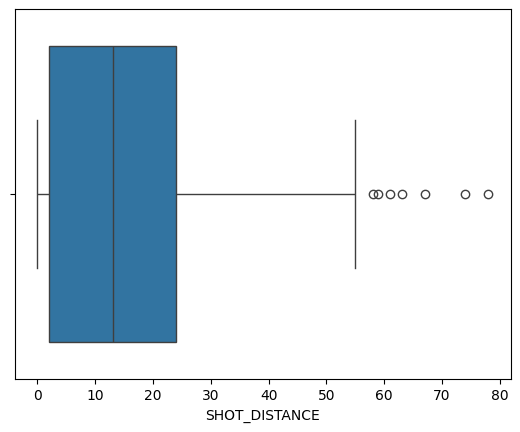

In [ ]:
sns.boxplot(x=data_file['SHOT_DISTANCE'])
plt.show()

In [ ]:
Q1 = data_file['SHOT_DISTANCE'].quantile(0.25)
Q3 = data_file['SHOT_DISTANCE'].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = (data_file['SHOT_DISTANCE'] < (Q1 - 1.5 * IQR)) | (data_file['SHOT_DISTANCE'] > (Q3 + 1.5 * IQR))
outliers = data_file[outlier_condition]
outliers

,SEASON_1,PLAYER_ID,HOME_TEAM,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_NAME,ZONE_RANGE,LOC_X,...,QUARTER,MINS_LEFT,SECS_LEFT,TIME_REMAINING,TIME_REMAINING_QUARTER,CONGESTION_PROXY,RELATIVE_SHOT_DIFFICULTY,SHOT_CONGESTION,SHOT_CONGESTION_NUMERIC,IS_CLUTCH
6336,2022,1630167,False,False,Running Jump Shot,3PT Field Goal,Backcourt,Back Court,Back Court Shot,-1.19,...,3,0,0,720,0,2.5,29.6,None,NaN,1
16073,2023,1630540,True,False,Jump Shot,3PT Field Goal,Backcourt,Back Court,Back Court Shot,-14.80,...,2,0,1,1441,1,2.5,23.2,None,NaN,1
16459,2023,1630193,False,False,Jump Shot,3PT Field Goal,Backcourt,Back Court,Back Court Shot,13.50,...,4,0,0,0,0,2.5,24.4,None,NaN,1
18299,2023,1630579,False,False,Jump Shot,3PT Field Goal,Backcourt,Back Court,Back Court Shot,16.90,...,3,0,0,720,0,2.5,23.6,None,NaN,1
24317,2024,1628978,False,False,Pullup Jump shot,3PT Field Goal,Backcourt,Back Court,Back Court Shot,11.20,...,2,0,0,1440,0,2.5,26.8,None,NaN,1
24976,2024,1628973,True,False,Jump Shot,3PT Field Goal,Backcourt,Back Court,Back Court Shot,0.50,...,3,0,0,720,0,2.5,25.2,None,NaN,1
26532,2024,1630540,False,False,Jump Shot,3PT Field Goal,Backcourt,Back Court,Back Court Shot,0.90,...,3,0,0,720,0,2.5,31.2,None,NaN,1


In [ ]:
data_file.shape

(27894, 22)

In [ ]:
data_file = data_file[~outlier_condition]
data_file.shape

(27887, 22)

**Result**: The 7 Outliers will be removed from the dataset as they are more of exceptions than the rule.

**2. A bar chart to show class distribution of the Shots Made vs Missed:**

<ipython-input-58-b54759cb8e35>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SHOT_MADE', data=df_sample, palette='viridis')


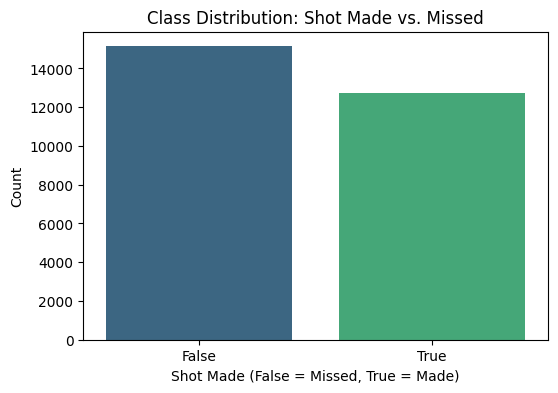

In [ ]:
#Class Distribution of Shot made vs Missed
plt.figure(figsize=(6, 4))
sns.countplot(x='SHOT_MADE', data=df_sample, palette='viridis')
plt.title('Class Distribution: Shot Made vs. Missed')
plt.xlabel('Shot Made (False = Missed, True = Made)')
plt.ylabel('Count')
plt.show()

**Result**: This shows that there is a noticeable dataset imbalance between shots missed and shots made. We will defining a function that make both the shots missed and shots made to be equal and balanced.

-------------------------------------------------------

**LOGISTIC REGRESSION:**

Logistic Regression is one of the most popular statistical models used for binary classification tasks. It predicts the probability of a binary outcome (e.g., Shot Made or Missed, in our case). The model uses the sigmoid function to map predictions to probabilities in the range between 0 to 1.

**Why was Logistic Regression Chosen for This Project?**
1. Logistic Regression was primarily chosen to serve as the **baseline model** to evaluate the dataset and assess predictive performance.

  Comparing other Advanced Models against logistic regression gives insights into whether added complexity is justified.

2. It is simple to implement as a model for initial analysis and as well accomodate newly engineered features and provide a quick way to assess their predictive power.

**IMPLEMENTATION STEPS**
1. Create a class Named Logistic Regression, define functions to calculate sigmoid function, computing cost, gradient descent and as well to predict the data.

2. Create a class named DataProcessor to preprocess the dataset.

3. Split the data into Training and Test sets in the main workflow.

4. Evaluate the performance of the model using metrics like Accuracy, Precision, Recall and F1-Score.

5. Based on the evaluation report, identify the root causes of the issues and how it can be optimized or fine tuned to improve the results.

**Class** **LogisticRegression**:

Define and calculate the sigmoid function, compute the cost, fit the training data, predict the test data.

In [ ]:
class LogisticRegression:
  def __init__(self, learning_rate=0.1, iterations=2000, class_weights=None, regularization=1.0):
    """
    Initialize the logistic Regression Model.
    :param learning_rate: Learning rate for gradient Descent.
    :param iterations: Number of iterations for Gradient Descent.
    :param class_weights: Dictionary of class weights for imbalanced data.
    :param regularization: Regularization parameter for L2 regularization.
    """
    self.learning_rate = learning_rate
    self.iterations = iterations
    self.weights = None
    self.bias = None
    self.class_weights = class_weights
    self.regularization = regularization

  def sigmoid(self, z):
    """
    Calculate the sigmoid function.
    :param z: Linear combination of inputs and weights.
    :return: Sigmoid output.
    """
    z = np.array(z, dtype=np.float64)
    # z = np.clip(z,-500, 500)
    return 1 / (1 + np.exp(-z))

  def compute_cost(self, y, y_prediction):
    """
    Calculate the binary cross-entropy loss.
    :param y: True Labels.
    :param y_prediction: Predicted probabilities.
    :return: Binary Cross-Entropy Loss.
    """
    m = len(y)
    if self.class_weights:
      weights = np.array([self.class_weights[label] for label in y])
      cost = -(1/m) * np.sum(weights * (y * np.log(y_prediction) + (1-y) * np.log(1-y_prediction)))
    else:
      cost = -(1/m) * np.sum(y * np.log(y_prediction) + (1-y) * np.log(1-y_prediction))
    #L2 Regularization penalty added
    cost += (self.regularization / (2 * m)) * np.sum(self.weights ** 2)
    return cost

  def gradient_descent(self, X, y):
    """
    Perform Gradient Descent to update weights and bias.
    :param X: Feature matrix.
    :param y: True labels.
    """
    m = len(y)
    for i in range(self.iterations):
      z = np.dot(X, self.weights) + self.bias
      y_prediction = self.sigmoid(z)

      if self.class_weights:
        weights = np.array([self.class_weights[label] for label in y])
        dw = (1/m) * np.dot(X.T, (y_prediction - y) * weights)
        db = (1/m) * np.sum((y_prediction - y) * weights)
      else:
        dw = (1/m) * np.dot(X.T, (y_prediction - y))
        db = (1/m) * np.sum(y_prediction - y)

      #L2 regularization added to gradients
      dw += (self.regularization / m) * self.weights

      self.weights -= self.learning_rate * dw
      self.bias -= self.learning_rate * db

      if i % 100 == 0:
        cost = self.compute_cost(y, y_prediction)
        print(f"Iteration {i}, Cost: {cost:.2f}")

  def fit(self, X, y):
      """
      Train the logistic regression model.
      :param X: Feature matrix.
      :param y: True labels.
      """
      n_features = X.shape[1]
      self.weights = np.zeros(n_features)
      self.bias = 0
      self.gradient_descent(X, y)

  def predict_probability(self, X):
      """
      Predict the probabilities for the input features.
      :param X: Feature matrix.
      :return: Predicted probabilities.
      """
      z = np.dot(X, self.weights) + self.bias
      y_prediction = self.sigmoid(z)
      return y_prediction

  def predict(self, X, threshold=0.5):
      """
      Predict binary labels for the input features.
      : param X: Feature matrix.
      :return: Predicted labels (0 or 1).
      """

      probabilities = self.predict_probability(X)
      return (probabilities >= threshold).astype(int)

  def feature_importance(self, feature_names):
    """
    Visualize feature importance based on the absolute values of weights.
    :param feature_names: feature names.
    """
    importance = abs(self.weights)

    if len(importance) != len(feature_names):
        raise ValueError(f"Mismatch: {len(importance)} weights vs {len(feature_names)} feature names.""Ensure feature names match the encoded feature set.")

    plt.figure(figsize=(20,10))
    plt.barh(feature_names, importance, color='blue')
    plt.xlabel('Importance (Absolute Weight Magnitude)')
    plt.ylabel('Features')
    plt.title('Feature Importance Visualization')
    plt.gca().invert_yaxis()
    plt.show()

  def drop_features(self, X, feature_names, threshold=0.02):
    """
    Drop features that are not important based on a valuation with a threshold.
    :param X: Feature matrix.
    :param feature_names: Names of the feature
    :param threshold: Threshold below which features are dropped.
    :return: New feature matrix with dropped features.
    """

    importance = abs(self.weights)
    important_indices = [i for i, val in enumerate(importance) if val >= threshold]
    filtered_X = X[:, important_indices]
    filtered_feature_names = [feature_names[i] for i in important_indices]
    print(f"Dropped Features: {[feature_names[i] for i, val in enumerate(importance) if val < threshold]}")
    return filtered_X, filtered_feature_names

  @staticmethod
  def tune_learning_rate_iterations(X, y, learning_rates, iteration_values):
    """
    Tune learning rates and iterations to find optimal values for model convergence.
    :param X: Feature matrix.
    :param y: True labels.
    :param learning_rates: List of learning rates to try.
    :param iteration_values: List of iterations to try.
    :return: Optimal learning rate and iterations.
    """

    best_learning_rate = None
    best_iterations = None
    best_cost = float('inf')

    for lr in learning_rates:
        for iters in iteration_values:
            model = LogisticRegression(learning_rate=lr, iterations=iters)
            model.fit(X, y)
            cost = model.compute_cost(y, model.predict_probability(X))
            print(f"Learning Rate: {lr}, Iterations: {iters}, Cost: {cost:.2f}")

            if cost < best_cost:
                best_cost = cost
                best_learning_rate = lr
                best_iterations = iters

    print(f"Best Learning Rate: {best_learning_rate}, Best Iterations: {best_iterations}, Best Cost: {best_cost:.2f}")
    return best_learning_rate, best_iterations


**Class DataProcessor**

Define a function to preprocess the data and perform basic pre processing, a function to evaluate the metrics for performance etc.,


In [ ]:
class DataProcessor:
  @staticmethod
  def load_and_preprocess(filepath):
    """
    Load and preprocess the dataset.
    :param filepath: Path to the dataset file.
    :return: Preprocessed data.
    """
    #Load the dataset
    data = pd.read_csv(filepath)

    #Kepping only the relevant columns
    relevant_columns = ['SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'ACTION_TYPE', 'SHOT_TYPE', 'RELATIVE_SHOT_DIFFICULTY', 'QUARTER', 'CONGESTION_PROXY', 'IS_CLUTCH', 'TIME_REMAINING_QUARTER', 'SHOT_MADE']
    data = data[relevant_columns]

    # # Drop rows with NaN in any column
    # data = data.dropna()

    #Convert target to binary (1 for 'made', 0 for 'missed')
    if 'SHOT_MADE' in data.columns:
      data['SHOT_MADE'] = data['SHOT_MADE'].apply(lambda x: 1 if x else 0)

    #Add interaction and polynomial terms
    data['SHOT_DISTANCE_x_CONGESTION'] = data['SHOT_DISTANCE'] * data['CONGESTION_PROXY']
    data['SHOT_DISTANCE_SQ'] = data['SHOT_DISTANCE'] ** 2
    data['LOC_X_SQ'] = data['LOC_X'] ** 2
    data['LOC_Y_SQ'] = data['LOC_Y'] ** 2

    #One-hot encoding
    categorical_features = ['ACTION_TYPE', 'SHOT_TYPE', 'QUARTER', 'IS_CLUTCH']
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_features = encoder.fit_transform(data[categorical_features])
    encoded_feature_names = encoder.get_feature_names_out(categorical_features)
    encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

    #Encoding numerical features
    numerical_features = ['LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'CONGESTION_PROXY', 'RELATIVE_SHOT_DIFFICULTY', 'TIME_REMAINING_QUARTER', 'SHOT_DISTANCE_x_CONGESTION', 'SHOT_DISTANCE_SQ', 'LOC_X_SQ', 'LOC_Y_SQ']
    for feature in numerical_features:
      if feature in data.columns:
        data[feature] = (data[feature] - data[feature].mean()) / data[feature].std()

    #Concatenate the data into one dataframe
    data = pd.concat([data[numerical_features], encoded_df, data['SHOT_MADE']], axis=1)

    #Define features names by combining both numerical and categorical features after encoding
    feature_names = numerical_features + list(encoded_feature_names)

    #Select relevant target
    target = 'SHOT_MADE'

    if target in data.columns:
      X = data.drop(columns=[target]).values
      y = data[target].values
    else:
      X = data.values
      y = None

    X = X.astype(np.float64)

    return X, y, feature_names

  @staticmethod
  def balance_dataset(data):
    """
    Balance the SHOT_MADE classes to ensure equal representation for Shots Made and Missed entries.
    :param data: DataFrame containing the dataset.
    :return: Balanced DataFrame.
    """

    made = data[data['SHOT_MADE'] == 1]
    missed = data[data['SHOT_MADE'] == 0]

    min_size = min(len(made), len(missed))

    made_balanced = made.sample(min_size, random_state=42)
    missed_balanced = missed.sample(min_size, random_state=42)

    balanced_data = pd.concat([made_balanced, missed_balanced]).sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_data


  @staticmethod
  def evaluate(y_true, y_prediction):
    """
    Evaluate model performance using metrics.
    :param y_true: True labels.
    :param y_prediction: Predicted labels.
    :return: Dictionary of evaluation metrics.
    """
    tp = np.sum((y_true == 1) * (y_prediction == 1))
    tn = np.sum((y_true == 0) * (y_prediction == 0))

    fp = np.sum((y_true == 0) * (y_prediction == 1))
    fn = np.sum((y_true == 1) * (y_prediction == 0))

    accuracy = np.mean(y_true == y_prediction)

    if (tp + fp) > 0:
      precision = tp / (tp + fp)
    else:
      precision = 0

    if (tp + fn) > 0:
      recall = tp / (tp + fn)
    else:
      recall = 0

    if (precision + recall) > 0:
      f1_score = (2 * precision * recall) / (precision + recall)
    else:
      f1_score = 0

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score
    }

    for metric, value in metrics.items():
      print(f"{metric.capitalize()}: {value * 100:.2f}%")

    return metrics

  @staticmethod
  def tune_threshold(y_true, y_probabilities):
    """
    Tune the decision thershold to maximize the F1-score.
    :param y_true: True labels.
    :param y_probabilities: Predicted probabilities.
    :return: Optimal threshold and corresponding metrics.
    """

    thresholds = np.arange(0.1, 0.9, 0.05)
    best_f1 = 0
    best_threshold = 0.5
    best_metrics = {}

    for threshold in thresholds:
      y_prediction = (y_probabilities >= threshold).astype(int)
      metrics = DataProcessor.evaluate(y_test, y_prediction)
      if metrics["F1-Score"] > best_f1:
        best_f1 = metrics["F1-Score"]
        best_threshold = threshold
        best_metrics = metrics

    # print(f"Optimal Thershold: {best_threshold:.2f}")
    # print("Best Metrics:", best_metrics)
    return best_threshold, best_metrics

**Main Workflow:**

Class distribution after SMOTE: [12756 12756]
Iteration 0, Cost: 0.69
Iteration 100, Cost: 0.67
Iteration 200, Cost: 0.66
Iteration 300, Cost: 0.66
Iteration 400, Cost: 0.66
Iteration 500, Cost: 0.66
Iteration 600, Cost: 0.66
Iteration 700, Cost: 0.66
Iteration 800, Cost: 0.66
Iteration 900, Cost: 0.65
Iteration 1000, Cost: 0.65
Iteration 1100, Cost: 0.65
Iteration 1200, Cost: 0.65
Iteration 1300, Cost: 0.65
Iteration 1400, Cost: 0.65
Iteration 1500, Cost: 0.65
Iteration 1600, Cost: 0.65
Iteration 1700, Cost: 0.65
Iteration 1800, Cost: 0.65
Iteration 1900, Cost: 0.65


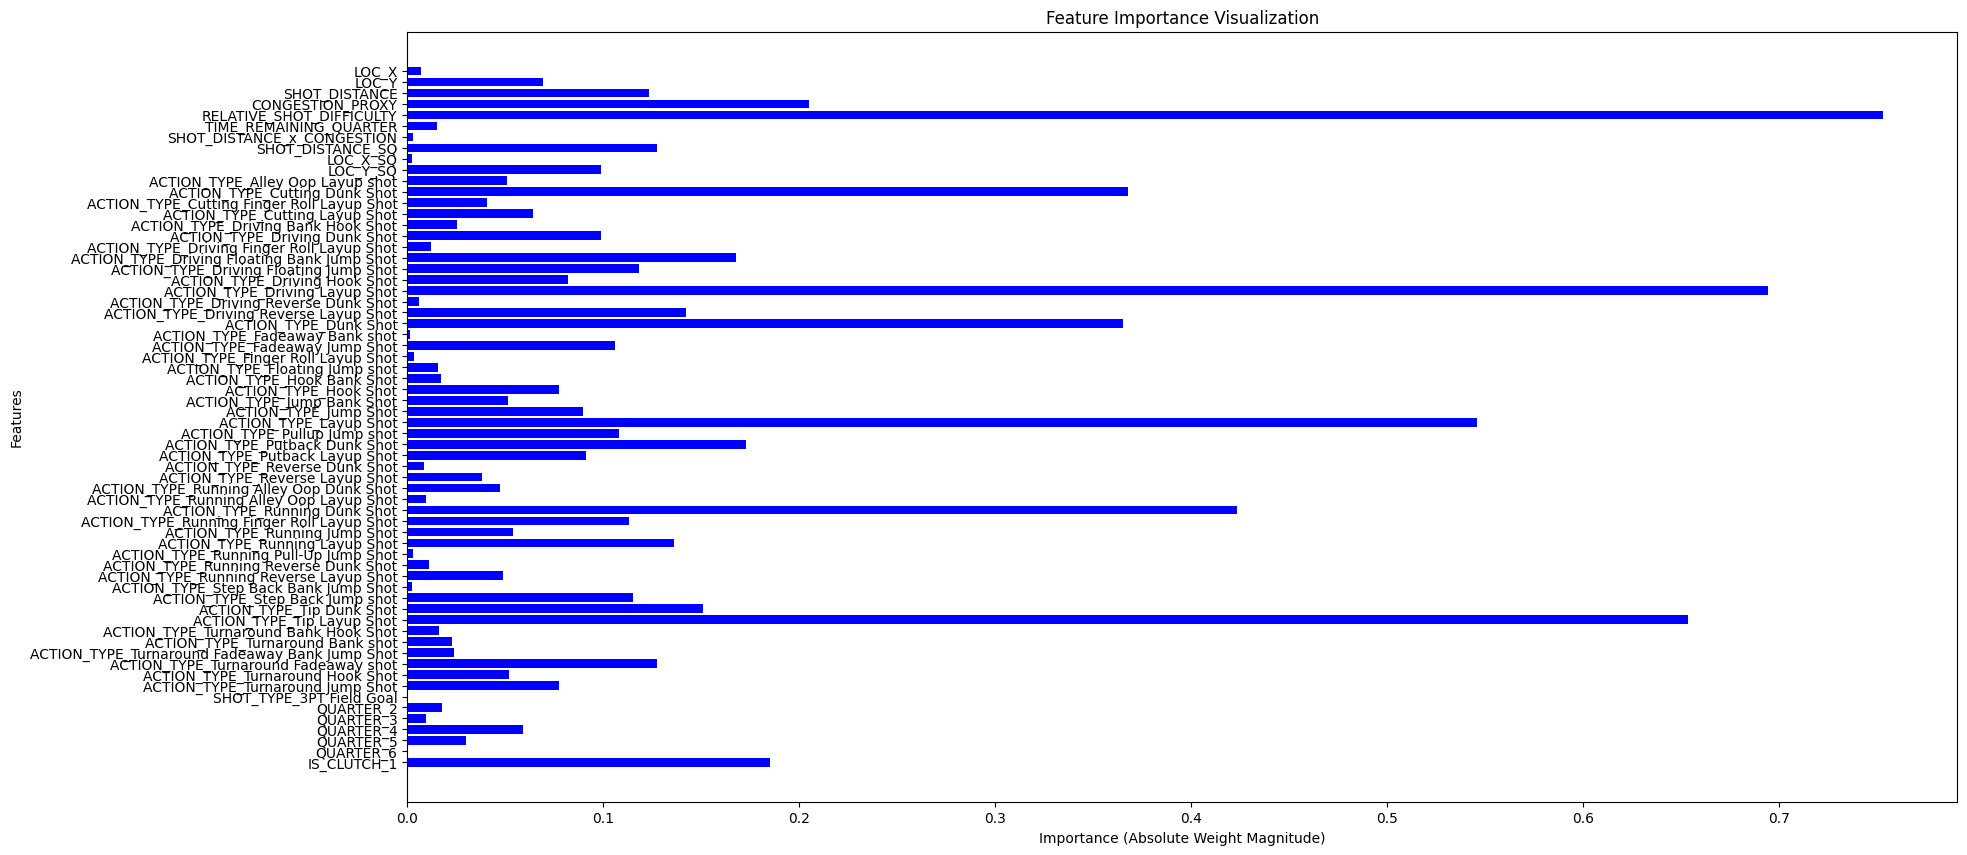

Dropped Features: ['LOC_X', 'TIME_REMAINING_QUARTER', 'SHOT_DISTANCE_x_CONGESTION', 'LOC_X_SQ', 'ACTION_TYPE_Driving Finger Roll Layup Shot', 'ACTION_TYPE_Driving Reverse Dunk Shot', 'ACTION_TYPE_Fadeaway Bank shot', 'ACTION_TYPE_Finger Roll Layup Shot', 'ACTION_TYPE_Floating Jump shot', 'ACTION_TYPE_Hook Bank Shot', 'ACTION_TYPE_Reverse Dunk Shot', 'ACTION_TYPE_Running Alley Oop Layup Shot', 'ACTION_TYPE_Running Pull-Up Jump Shot', 'ACTION_TYPE_Running Reverse Dunk Shot', 'ACTION_TYPE_Step Back Bank Jump Shot', 'ACTION_TYPE_Turnaround Bank Hook Shot', 'SHOT_TYPE_3PT Field Goal', 'QUARTER_2', 'QUARTER_3', 'QUARTER_6']
Dropped Features: ['LOC_X', 'TIME_REMAINING_QUARTER', 'SHOT_DISTANCE_x_CONGESTION', 'LOC_X_SQ', 'ACTION_TYPE_Driving Finger Roll Layup Shot', 'ACTION_TYPE_Driving Reverse Dunk Shot', 'ACTION_TYPE_Fadeaway Bank shot', 'ACTION_TYPE_Finger Roll Layup Shot', 'ACTION_TYPE_Floating Jump shot', 'ACTION_TYPE_Hook Bank Shot', 'ACTION_TYPE_Reverse Dunk Shot', 'ACTION_TYPE_Running A

In [ ]:
if __name__ == "__main__":
    # Load and preprocess dataset
    filepath = "final.xls"
    processor = DataProcessor()
    raw_data = pd.read_csv(filepath)

    # Balance the classes
    balanced_data = processor.balance_dataset(raw_data)

    # Save the balanced dataset
    balanced_filepath = "Balanced_data.csv"
    balanced_data.to_csv(balanced_filepath, index=False)

    # Preprocess the balanced dataset
    X, y, feature_names = processor.load_and_preprocess(balanced_filepath)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    print(f"Class distribution after SMOTE: {np.bincount(y_resampled)}")

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    model = LogisticRegression(learning_rate=0.1, iterations=2000, class_weights=None, regularization=1.0)
    model.fit(X_train, y_train)

    model.feature_importance(feature_names)

    X_train_filtered, filtered_feature_names = model.drop_features(X_train, feature_names, threshold=0.02)
    X_test_filtered, _ = model.drop_features(X_test, feature_names, threshold=0.02)

    model.fit(X_train_filtered, y_train)

    # Predict and evaluate
    y_prediction_test = model.predict(X_test_filtered)
    print("Final Test Set Evaluation:")
    processor.evaluate(y_test, y_prediction_test)


**Analyzing the RESULTS:**

In [ ]:
y_train_proba = model.predict_probability(X_train)
y_test_proba = model.predict_probability(X_test)
y_pred = model.predict(X_test)

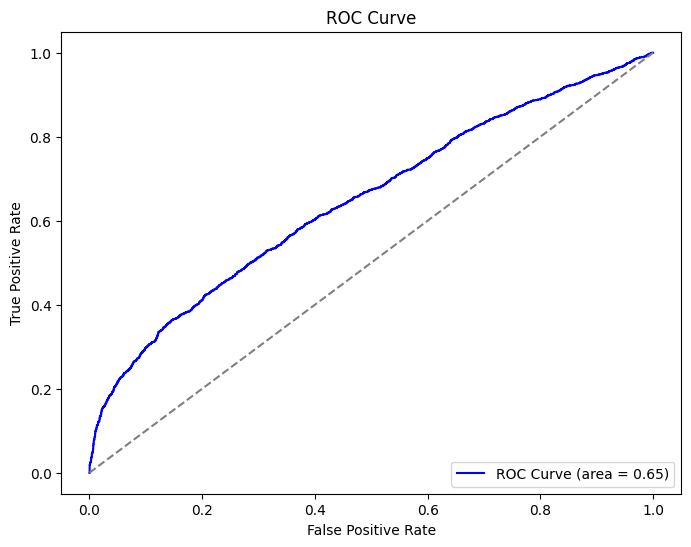

In [ ]:
# ------------------- ROC Curve -------------------
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

**OBSERVATION FOR ROC Curve:**

The curve isabove the random classifier line, indicating that it performs better than a random guess, but is still not very steep and it struggles to perfectly distinguish between positive and negative classes, in this case shot made or shot missed.

The area value is 0.65 which again confirms that it is slightly better than a random guess.

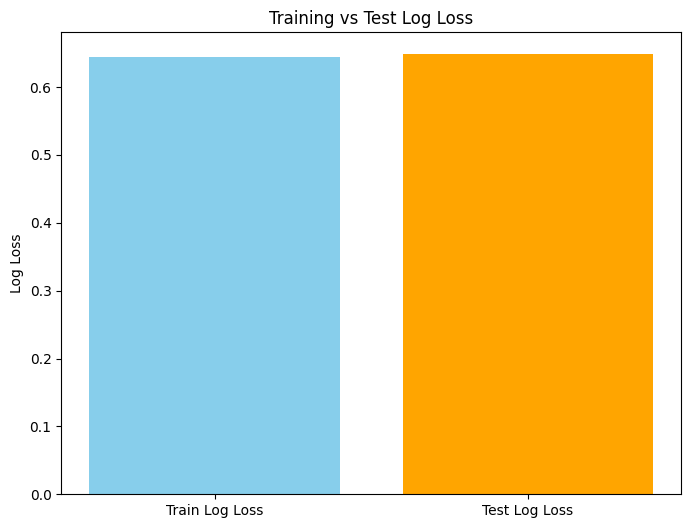

In [ ]:
# ------------------- Log Loss Plot -------------------
train_log_loss = log_loss(y_train, log_reg.predict_proba(X_train)[:, 1])
test_log_loss = log_loss(y_test, log_reg.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.bar(["Train Log Loss", "Test Log Loss"], [train_log_loss, test_log_loss], color=['skyblue', 'orange'])
plt.title("Training vs Test Log Loss")
plt.ylabel("Log Loss")
plt.show()

**OBSERVATION FOR Log Loss Plot:**

The training and test log loss values are nearly identical in the bar chart. This can be considered as a positive indicator that the model in not overfitting.

This can also suggest that the model has reached a balance between bias and variance.

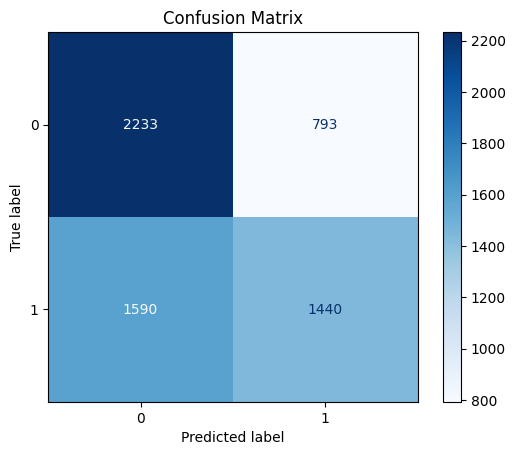

In [ ]:
# ------------------- Confusion Matrix -------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

**OBSERVATION FOR CONFUSION MATRIX:**

True Negative = 2233 -> Class 0 (Missed Shots)
False Positive = 793 -> Model wrongly predicts made shots as missed
False Negatives = 1590 -> Model wrongly predicts missed shots as made
True Positives = 1440 -> Class 1 (Made Shots)

With more true negatives than true positives, he model is biased towards predicting missed shots.

False Negatives are high too, which indicates that the model has low recall and needs improvement.

The confusion Matrix reveals that the model is biased towards predicting missed shots.

In [ ]:
print("Performing Cross-Validation...")
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cross_val_metrics = []
for train_index, val_index in skf.split(X_train, y_train):
    X_cv_train, X_cv_val = X_train[train_index], X_train[val_index]
    y_cv_train, y_cv_val = y_train[train_index], y_train[val_index]

    model.fit(X_cv_train, y_cv_train)
    y_cv_pred = model.predict(X_cv_val)
    metrics = processor.evaluate(y_cv_val, y_cv_pred)
    cross_val_metrics.append(metrics)

print("Cross-Validation Results:")
for fold_idx, fold_metrics in enumerate(cross_val_metrics):
    print(f"Fold {fold_idx + 1}:")
    for metric_name, metric_value in fold_metrics.items():
        print(f"  {metric_name}: {metric_value:.2f}")

Performing Cross-Validation...
Iteration 0, Cost: 0.69
Iteration 100, Cost: 0.65
Iteration 200, Cost: 0.65
Iteration 300, Cost: 0.65
Iteration 400, Cost: 0.65
Iteration 500, Cost: 0.65
Iteration 600, Cost: 0.65
Iteration 700, Cost: 0.65
Iteration 800, Cost: 0.65
Iteration 900, Cost: 0.65
Iteration 1000, Cost: 0.65
Iteration 1100, Cost: 0.65
Iteration 1200, Cost: 0.65
Iteration 1300, Cost: 0.65
Iteration 1400, Cost: 0.65
Iteration 1500, Cost: 0.65
Iteration 1600, Cost: 0.64
Iteration 1700, Cost: 0.64
Iteration 1800, Cost: 0.64
Iteration 1900, Cost: 0.64
Accuracy: 60.76%
Precision: 64.74%
Recall: 47.17%
F1-score: 54.58%
Iteration 0, Cost: 0.69
Iteration 100, Cost: 0.65
Iteration 200, Cost: 0.65
Iteration 300, Cost: 0.65
Iteration 400, Cost: 0.65
Iteration 500, Cost: 0.65
Iteration 600, Cost: 0.65
Iteration 700, Cost: 0.65
Iteration 800, Cost: 0.65
Iteration 900, Cost: 0.65
Iteration 1000, Cost: 0.65
Iteration 1100, Cost: 0.65
Iteration 1200, Cost: 0.65
Iteration 1300, Cost: 0.65
Iteratio

**Observation for Cross-Validation:**
Accuracy:

The accuracy ranges between 0.60 (60%) and 0.62 (62%) across the folds.

This shows consistent performance but indicates that the model is not achieving higher accuracy, possibly due to:
1. Class imbalance (even post-SMOTE, slight imbalance can persist).

Precision:
Higher precision (~65%) shows the model is good at avoiding false positives.

Recall:
Recall is relatively low, ranging from 0.46 to 0.50.

F1-Score:
The F1-score hovers between 0.54 and 0.57, combining both precision and recall.

It is low due to lower recall.


_______________________________________________________

**CONCLUSION**: The Model was fine tuned and optimized for hyper parameters for different regularization values, for different thresholds, for different learning rates, introducing class weights to balance classes and SMOTE was added to address any imbalance in classes and these were the results obtained after performing all of the above steps:

Final Test Set Evaluation:
Accuracy: 61.18%
Precision: 65.62%
Recall: 48.13%
F1-score: 55.53%


The logistic Regression model provides a reasonable baseline with an accuracy of 61.18% and precision of 65.62%. However even after feature engineering, pre processing, finding the optimum learning rate, iterations, regularization value, threshold value, the recall is lower and highlights that a more complex model can perform better and understand better the non-linear relations between features in the dataset.

________________________________________________________


**SUPPORT VECTOR MACHINES**

Support Vector Machines (SVM) are powerful supervised learning algorithms that are quite good at handling both linear and non-linear relationships effectively.

**Why SVM for this project?**

The dataset exhibhits non-linear relationships (eg, SHOT_DISTANCE vs CONGESTION_PROXY), making SVM and their use of kernals in non-linear relationship datasets a good idea.

It works well on small to medium-sized datasets with high-dimensional features.


**IMPLEMENTATION STEPS:**

1. Load and preprocess the data, using the load_and_preprocess function defined earlier.

2. Model training and Testing with different kernals like RBF, Poly, linear.

3. Compare and observe the results

4. Visualize Insights



_______________________________________________________

**SVM IMPLEMENTATION WITH RBF KERNAL:**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

# Main Workflow
if __name__ == "__main__":
    # Load and preprocess dataset
    filepath = "final.xls"
    processor = DataProcessor()

    # Preprocess the dataset and get feature names
    X, y, feature_names = processor.load_and_preprocess(filepath)

    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"Class distribution after SMOTE: {pd.Series(y_resampled).value_counts()}")

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # Train the SVM model
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
    svm_model.fit(X_train, y_train)

    # Predict on test set
    y_pred_test = svm_model.predict(X_test)
    y_proba_test = svm_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for threshold tuning

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)

    print("\nSVM Model Evaluation:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-Score: {f1 * 100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_test))


Class distribution after SMOTE: 0    15138
1    15138
Name: count, dtype: int64

SVM Model Evaluation:
Accuracy: 61.56%
Precision: 65.61%
Recall: 48.68%
F1-Score: 55.89%

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.74      0.66      3026
           1       0.66      0.49      0.56      3030

    accuracy                           0.62      6056
   macro avg       0.62      0.62      0.61      6056
weighted avg       0.62      0.62      0.61      6056



**OBSERVATION FOR RBF KERNAL IMPLEMENTATION:**

1. The RBF kernel performs well for the missed shots (Class 0) but struggles to recall made shots (Class 1). This highlights that the non-linear patterns captured by the RBF kernel primarily benefit one class.

2. Precision for predicting made shots (0.66) is reasonable, but improving recall (49%) will be critical for improving the model's F1-score and overall robustness.

________________________________________________________

**SVM IMPLEMENTATION WITH LINEAR KERNAL:**

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import pandas as pd

if __name__ == "__main__":
    filepath = "final.xls"
    processor = DataProcessor()

    # Preprocess and SMOTE
    X, y, feature_names = processor.load_and_preprocess(filepath)
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train SVM with a linear kernel
    print("Training SVM...")
    svm_model = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
    svm_model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred_test = svm_model.predict(X_test)
    print("SVM Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_test) * 100:.2f}%")
    print(f"Precision: {precision_score(y_test, y_pred_test) * 100:.2f}%")
    print(f"Recall: {recall_score(y_test, y_pred_test) * 100:.2f}%")
    print(f"F1-Score: {f1_score(y_test, y_pred_test) * 100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_test))


Training SVM...
SVM Evaluation:
Accuracy: 60.82%
Precision: 66.72%
Recall: 43.27%
F1-Score: 52.49%

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.78      0.67      3026
           1       0.67      0.43      0.52      3030

    accuracy                           0.61      6056
   macro avg       0.62      0.61      0.60      6056
weighted avg       0.62      0.61      0.60      6056



**OBSERVATION FOR SVM WITH LINEAR KERNAL:**

1. The linear kernel performs well for missed shots (Class 0), particularly with high recall (78%).

2. However, it struggles to recall made shots (Class 1), which results in a lower F1-score compared to the RBF kernel.

3. It does not perform better than the RBF kernal implementation.



________________________________________________________

**SVM IMPLEMENTATION WITH POLY KERNAL:**

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import pandas as pd

if __name__ == "__main__":
    filepath = "final.xls"
    processor = DataProcessor()

    # Preprocess and SMOTE
    X, y, feature_names = processor.load_and_preprocess(filepath)
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train SVM with a linear kernel
    print("Training SVM...")
    svm_model = SVC(kernel='poly', C=1.0, probability=True, random_state=42)
    svm_model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred_test = svm_model.predict(X_test)
    print("SVM Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_test) * 100:.2f}%")
    print(f"Precision: {precision_score(y_test, y_pred_test) * 100:.2f}%")
    print(f"Recall: {recall_score(y_test, y_pred_test) * 100:.2f}%")
    print(f"F1-Score: {f1_score(y_test, y_pred_test) * 100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_test))


Training SVM...
SVM Evaluation:
Accuracy: 60.68%
Precision: 65.06%
Recall: 46.27%
F1-Score: 54.08%

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.75      0.66      3026
           1       0.65      0.46      0.54      3030

    accuracy                           0.61      6056
   macro avg       0.62      0.61      0.60      6056
weighted avg       0.62      0.61      0.60      6056



**OBSERVATION OFR SVM IMPLEMENTATION WITH POLY KERNAL:**


1. The polynomial kernel shows an intermediate performance between the linear and RBF kernels.

2. It improves recall for made shots (Class 1) compared to the linear kernel but does not perform as well as the RBF kernel in capturing non-linear relationships.



________________________________________________________

**FINE TUNING SVM rbf Kernal Implementation using Grid Search**

The parameters fine-tuned include c: Regularzation value, gamma - determining the influence of a single training example on the decision boundary.

Grid Search will find the optimal c nad gamma vlaues

Final Model Evaluation

**VISUALIZATION**

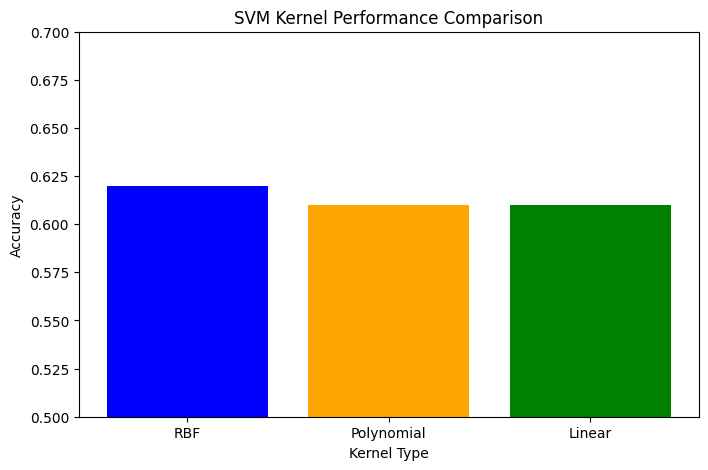

In [ ]:
# Accuracy values obtained from SVM kernel results
kernels = ['RBF', 'Polynomial', 'Linear']
accuracies = [0.62, 0.61, 0.61]

plt.figure(figsize=(8, 5))
plt.bar(kernels, accuracies, color=['blue', 'orange', 'green'])
plt.title("SVM Kernel Performance Comparison")
plt.xlabel("Kernel Type")
plt.ylabel("Accuracy")
plt.ylim(0.5, 0.7)
plt.show()


**OBSERVATION:**

This shows that the RBF kernal performs better on this dataset on non-linear relationships.

The model can be further optimised on different c values to tune the hyper paramerters.
